# Neighbour Extraction using Gram Matrices

---

In [1]:
import sys
print(sys.executable)
print(sys.version)

/home/kshitij98/getNeighbours/venv/bin/python3
3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]


In [2]:
from ipynb.fs.full.Helper import getDataLoader, getNames, dist
from ipynb.fs.full.GramMatrix import convertModel, GramMatrixLayer
from ipynb.fs.full.LabelDataset import createDirectories

import torch
import torch.nn as nn

%matplotlib inline

---

## Feature Extraction

In [ ]:
loader = getDataLoader('/scratch/bam_subset_2_0', batch_size=4, shuffle=False, num_workers=4, testing=True)

In [ ]:
import torchvision.models as models
vgg19 = models.vgg19(pretrained=True)

In [ ]:
gramMatrixLayers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
vgg19, model, gram_matrices = convertModel(vgg19, gramMatrixLayers, testing=False)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model.eval()
model.to(device)

In [ ]:
dataIter = iter(loader)

(data, classes), names = dataIter.next()
data = data.cuda()
out = model(data)
G = []
for layer in gram_matrices:
    G.append(layer.gramMatrix)
G = torch.cat(G, 1)

a, D = G.size()

print(D)

Find a ‘safe’ number of components to randomly project to

The distortion introduced by a random projection p only changes the distance between two points by a factor (1 +- eps) in an euclidean space with good probability.

In [ ]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

# TODO: Remove hardcoded dataset size
K = johnson_lindenstrauss_min_dim(121000, eps=0.3)

print(K)

In [ ]:
from sklearn.random_projection import gaussian_random_matrix

RPM = gaussian_random_matrix(K, D)
RPM = RPM.transpose()
print(RPM.shape)

In [ ]:
import os

if not os.path.exists('/scratch/kshitij98'):
    print("Creating", '/scratch/kshitij98')
    os.makedirs('/scratch/kshitij98')

RPM = torch.from_numpy(RPM)
RPM = RPM.cuda()
RPM = RPM.float()
print(RPM.shape)

torch.save(RPM, "/scratch/kshitij98/rpm")

In [ ]:
import time

createDirectories('/scratch/bam_subset_2_0_features/')

dataIter = iter(loader)
t = time.time()

# TODO: Remove hardcoded dataset size
for i in range(30250):
    (data, classes), names = dataIter.next()
    data = data.cuda()
    out = model(data)
    G = []
    for layer in gram_matrices:
        G.append(layer.gramMatrix)
    G = torch.cat(G, 1)
    G = torch.mm(G, RPM)
    for j, gm in enumerate(G):
        torch.save(gm, names[j].replace('bam_subset_2_0', 'bam_subset_2_0_features'))
    print(i+1, "\tETA: ", ((time.time() - t) / ((i + 1) * 4)) * (121000 - ((i+1) * 4)) * (1 / 60), "minutes", end='\r')

---

## Get Neighbours

In [ ]:
import time

t = time.time()

names = getNames('/scratch/bam_subset_2_0_features/')
X = []
for i, fileName in enumerate(names):
    X.append(torch.load(fileName))
    print("ETA: ", (len(names) - i - 1) * ((time.time() - t) / (i+1)), end='\r')
X = torch.stack(X, 0)
print(X.shape)

In [ ]:
createDirectories('/scratch/bam_subset_2_0_top_neighbours/')
createDirectories('/scratch/bam_subset_2_0_bottom_neighbours/')

In [ ]:
import numpy as np

k = 15
t = time.time()

for i, source in enumerate(X):
    source = torch.unsqueeze(source, 0)

    d = dist(source, X)
    d, indices = d.sort()

    topIds = indices[0, 1:k+1]
    # Note: Negative slicing is not supported
    bottomIds = indices[0, -k:]

    top = []
    for idx in topIds:
        top.append(names[idx].replace('bam_subset_2_0_features', 'bam_subset_2_0'))
    top = np.asarray(top)
    
    bottom = []
    for idx in bottomIds:
        bottom.append(names[idx])
    bottom = np.asarray(bottom)
    
    np.save(names[i].replace('bam_subset_2_0_features', 'bam_subset_2_0_top_neighbours'), top)
    np.save(names[i].replace('bam_subset_2_0_features', 'bam_subset_2_0_bottom_neighbours'), bottom)

    print("ETA: ", (len(X) - i - 1) * ((time.time() - t) / (i+1)) * (1 / 60), end='\r')

---

## Statistics

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

names = getNames('/scratch/bam_subset_2_0_top_neighbours/', shuffle=True)

def showImages(images):
    fig = plt.figure(figsize=(32, 32))
    columns = 5
    rows = 4
    for i in range(1, len(images) + 1):
        img = images[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()

idx = 0
def showNeighbours(index = None):
    global idx
    if index is not None:
        idx = index
    nbs = np.load(names[idx])
    images = []
    images.append(Image.open(names[idx].replace('_top_neighbours', '').replace('.npy', '')))
    for nb in nbs:
        nb = nb.replace('bam_subset_2_0_features', 'bam_subset_2_0')
        images.append(Image.open(nb))
    showImages(images)
    idx += 1


#### Qualitatively test results

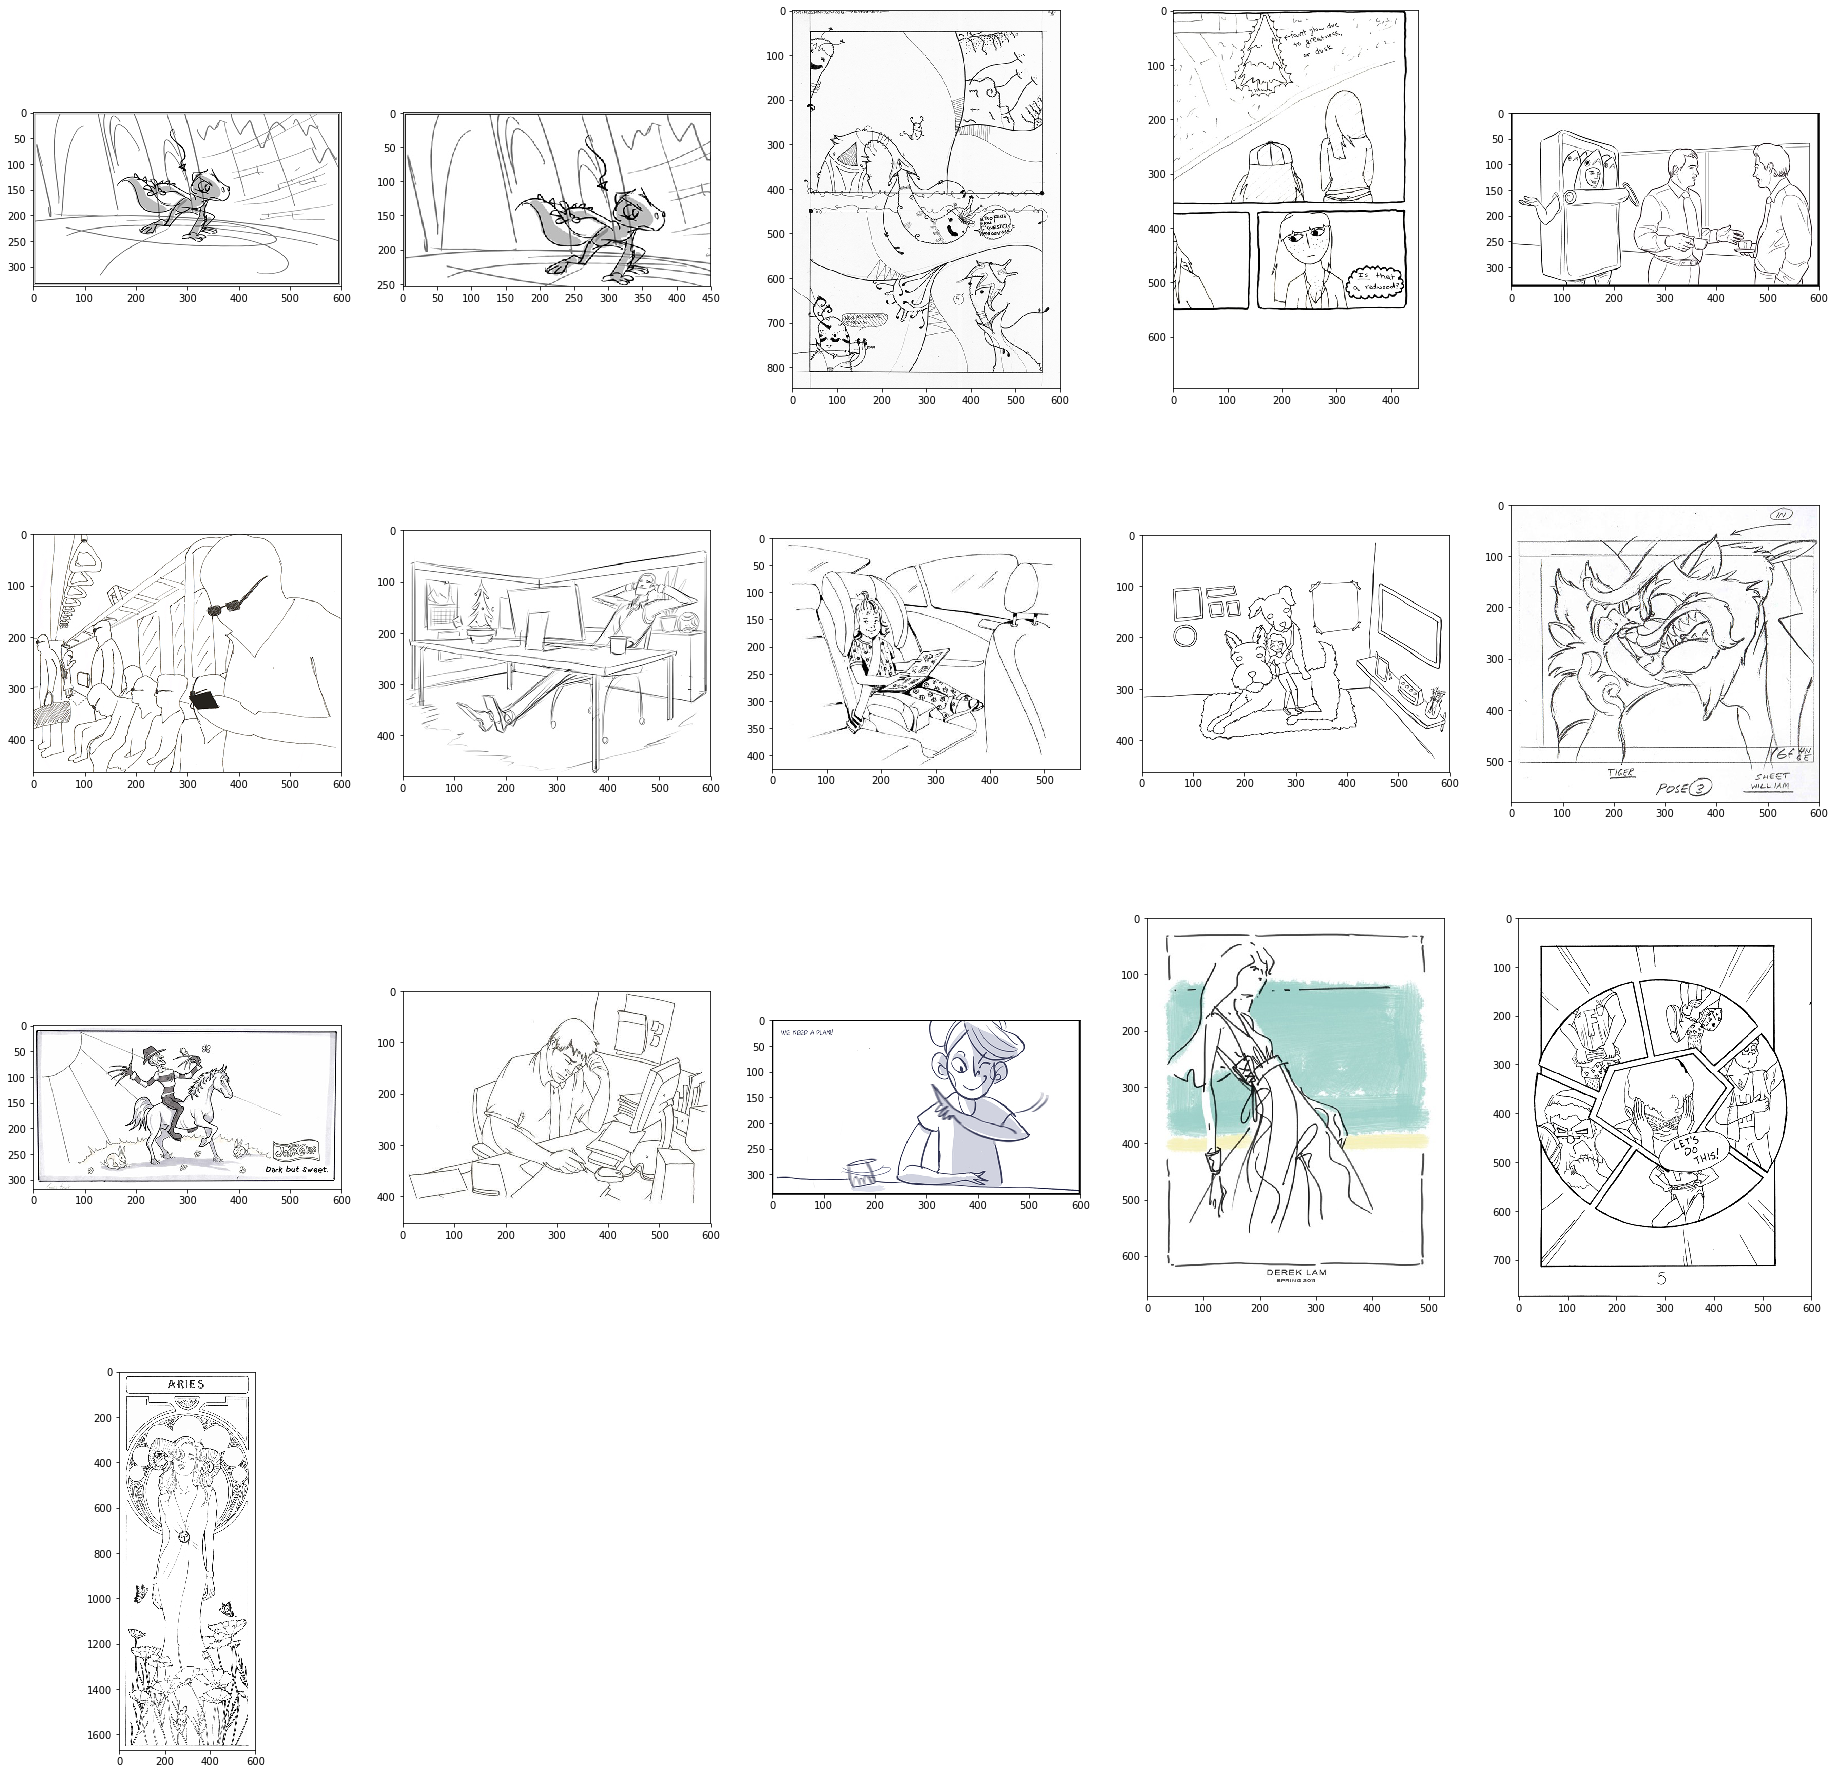

In [4]:
showNeighbours()

In [11]:
import pickle

labels = None
with open('../bam_2_0_image_style_labels.pkl', 'rb') as handle:
    labels = pickle.load(handle)

print(len(labels))

idx2 = 0

names = getNames('/scratch/bam_subset_2_0_top_neighbours/', shuffle=True)

def getTopAccuracy(n):
    total = 0
    correct = 0
    mini = 1000000
    worst = None
    for i in range(n):
        truth = labels[names[i].split('/')[-1].replace('.npy', '')]
        nbs = np.load(names[i])
#         print(truth)
        curr = 0
        l = []
        for nb in nbs:
            nb = nb.split('/')[-1]
            l.append(labels[nb])
            if truth == labels[nb]:
                curr += 1
#             print(labels[nb])
            total += 1
        if curr < mini:
            mini = curr
            worst = i
            actual = truth
            nb_labels = l
        correct += curr
    showNeighbours(worst)
    print(mini, " / 15 are correct neighbours")
    print("Actual label", actual)
    print("Neighbour labels: ", nb_labels)
    return str((correct / total) * 100) + " %"

121000


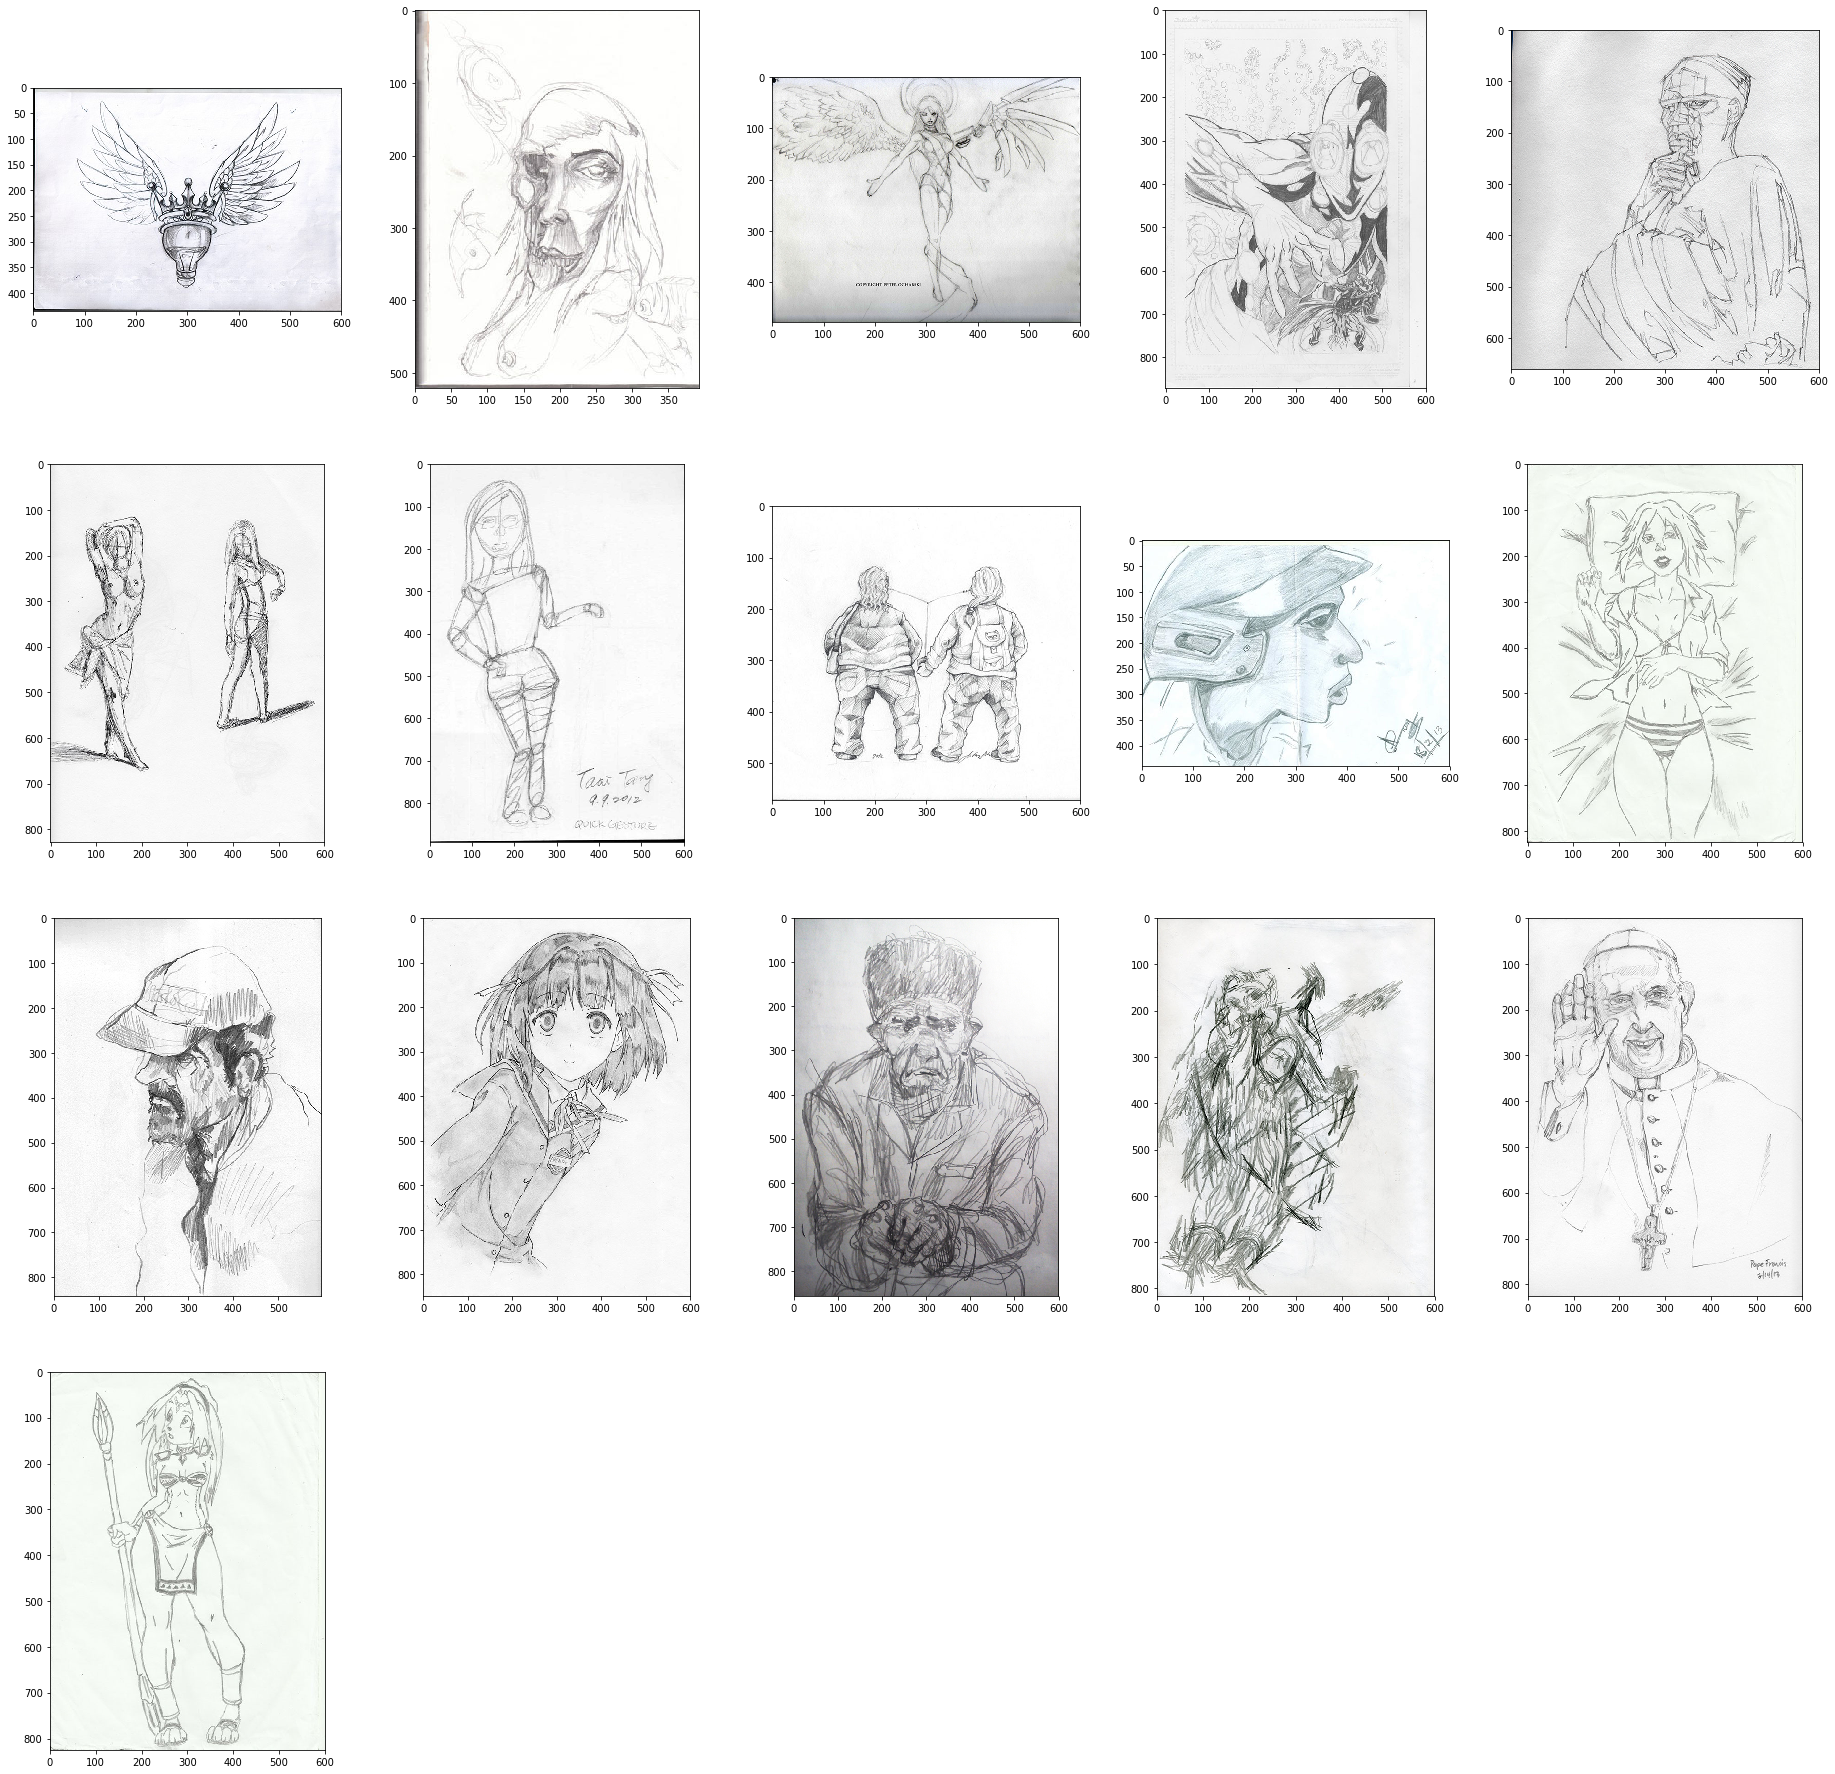

0  / 15 are correct neighbours
Actual label 1
Neighbour labels:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
69.35333333333334 %


In [12]:
print(getTopAccuracy(1000))